In [1]:
import wrds
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,roc_curve,auc
from scipy.stats.mstats import winsorize

In [2]:
db = wrds.Connection(wrds_username='laggythewhale')

Loading library list...
Done


# Preprocessing

In [3]:
#create table from compustat financial data
sample = db.raw_sql("""
                      select 
                      a.FYEAR as Fiscal_Year,
                      a.gvkey,
                      a.CIK,
                      b.SIC,
                      a.CHE as Current_Cash,
                      a.PPENT as PPE,
                      a.DP as Depreciation,
                      a.ACT as Current_Assets,
                      a.AT as Total_Assets,
                      a.LCT as Current_liabilities,
                      a.SALE as Rev,
                      a.DLC as current_debt,
                      a.RECT as receivables_total,
                      a.DN,
                      a.NI,
                      a.CAPS,
                      a.CSTKCV,
                      a.DUDD,
                      a.DPACT
                      FROM comp.funda as a
                      LEFT JOIN comp.company as b  
                      ON a.gvkey=b.gvkey
                      WHERE SIC NOT BETWEEN '4400' AND '5000'
                            AND SIC NOT BETWEEN '6000' AND '6500'
                            AND FYEAR BETWEEN '2011' AND '2021'
                            AND INDFMT = 'INDL'
                            AND DATAFMT = 'STD'
                            AND POPSRC = 'D'
                            AND CONSOL = 'C' 
                      """)

sample.dropna(inplace=True)

In [4]:
#create table from Restatement Audit Analytics data
sample2 = db.raw_sql("""
                      select
                      company_fkey,
                      res_begin_date,
                      res_end_date,
                      res_sec_invest
                      FROM audit.auditnonreli
                      """)

sample2.dropna(inplace=True)

In [5]:
sample['sic']=sample['sic'].apply(lambda x: int(str(x)[:2]))
sample['sic'] = sample['sic'].astype(str)

In [6]:
#creating "delta" and lag variables for later use
sample['rev_diff']=sample.groupby('gvkey')['rev'].diff()
sample['current_assets_diff']=sample.groupby('gvkey')['current_assets'].diff()
sample['current_cash_diff']=sample.groupby('gvkey')['current_cash'].diff()
sample['current_liabilities_diff']=sample.groupby('gvkey')['current_liabilities'].diff()
sample['current_debt_diff']=sample.groupby('gvkey')['current_debt'].diff()
sample['receivables_total_diff']=sample.groupby('gvkey')['receivables_total'].diff()
sample['lag_total_assets']=sample.groupby(['gvkey'])['total_assets'].shift(1)

sample.dropna(inplace=True)
sample=sample[sample['lag_total_assets'] != 0]

In [7]:
#function for the new column to identify restatement which can be 0 or 1
def check_condition(row):
    cik = row['cik']
    fiscal_year = int(row['fiscal_year'])
    sample2_subset = sample2[sample2['company_fkey'] == cik]
    for _, sample2_row in sample2_subset.iterrows():
        if sample2_row['res_begin_date'].year <= fiscal_year <= sample2_row['res_end_date'].year:
            return 1
    return 0

# apply the function to create the 'restatement' column
sample['restatement'] = sample.apply(check_condition, axis=1)

In [8]:
#identify if res_sec_invest is 0 or 1
sample['res_sec_invest'] = 0
res_mask = sample2['res_sec_invest'] == 1

for i, row in sample2[res_mask].iterrows():
    cik_mask = sample['cik'] == row['company_fkey']
    fy_mask = (sample['fiscal_year'].astype(int) >= row['res_begin_date'].year) & (sample['fiscal_year'].astype(int) <= row['res_end_date'].year)
    sample.loc[cik_mask & fy_mask, 'res_sec_invest'] = 1


In [9]:
#define function to apply linear regression with intercept
def regress(data, yvar,xvars):
    Y=data[yvar]
    X=data[xvars]
    X['intercept']=1
    result=sm.OLS(Y,X).fit()
    return result.params

In [10]:
#define function to apply linear regression with out intercept
def regress_wo_intercept(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    result = sm.OLS(Y, X).fit()
    return result.params

# Investigate earnings quality (EQ) differences between restating and non-restating firms using three models and two restatement outcomes.

### Model 1: Jones model

In [11]:
df=sample.copy()

In [12]:
df = df[~df['fiscal_year'].isin([2019, 2020, 2021])]

In [13]:
#creating Y and Xs
df['Y']=(df['current_assets_diff']-df['current_cash_diff']-df['current_liabilities_diff']-df['depreciation'])/df['lag_total_assets']
df['var1']=1/df['lag_total_assets']
df['var2']=df['rev_diff']/df['lag_total_assets']
df['var3']=df['ppe']/df['lag_total_assets']

In [14]:
#get the coeffs
jones_coeff=df.groupby(['fiscal_year','sic']).apply(regress,'Y',['var1','var2','var3'])

In [15]:
jones_coeff.to_csv('jones_coeff.csv')
Parameters=pd.read_csv('jones_coeff.csv')

In [16]:
Parameters.rename(columns={'var1': 'b1', 'var2': 'b2', 'var3': 'b3','intercept':'b0'}, inplace=True)
Parameters['sic'] = Parameters['sic'].astype(str)

In [17]:
#merged two dataset and calculate residuals
merged_df = pd.merge(df, Parameters, on=['fiscal_year', 'sic'], how='left')
merged_df['res']=(merged_df['Y']-(merged_df['b0']+merged_df['b1']*merged_df['var1']+merged_df['b2']*merged_df['var2']+merged_df['b3']*merged_df['var3'])).abs()

In [18]:
merged_df.groupby(['restatement'])['res'].agg('mean')

restatement
0    2.135521
1    3.118575
Name: res, dtype: float64

In [19]:
merged_df.groupby(['res_sec_invest'])['res'].agg('mean')

res_sec_invest
0    2.244157
1    1.421932
Name: res, dtype: float64

In [20]:
X = merged_df['res']
Y = merged_df['restatement']

result1 = sm.Logit(Y, X).fit()
result1.summary()

Optimization terminated successfully.
         Current function value: 0.674763
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            restatement   No. Observations:                31779
Model:                          Logit   Df Residuals:                    31778
Method:                           MLE   Df Model:                            0
Date:                Sat, 08 Apr 2023   Pseudo R-squ.:                  -1.015
Time:                        19:26:02   Log-Likelihood:                -21443.
converged:                       True   LL-Null:                       -10644.
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
res           -0.1510      0.006    -23.747      0.000      -0.163      -0.139
==============================================================================
"""

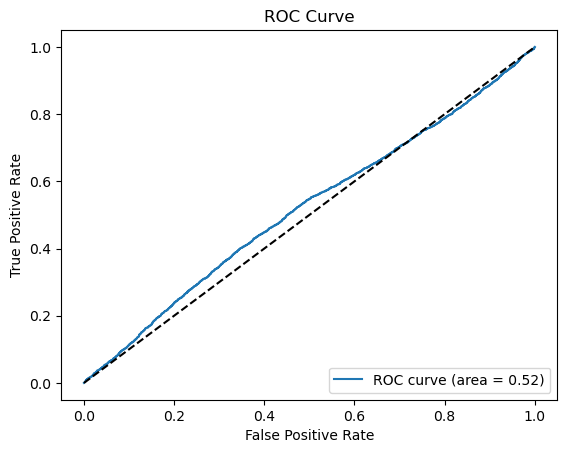

Optimal Threshold: 0.4934386732624767


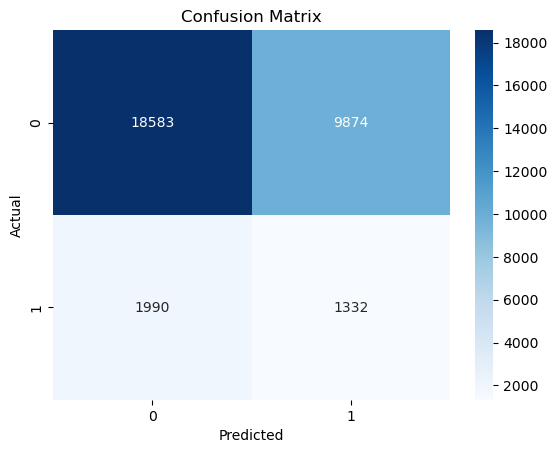

Type 1 Error: 0.34697965351231685
Type 2 Error: 0.5990367248645394


In [21]:
# calculate fpr and tpr for different threshold values
Y_pred = result1.predict(X)
fpr, tpr, thresholds = roc_curve(Y, Y_pred)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# find the threshold that maximizes the AUC
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

Y_pred_class = np.where(Y_pred >= optimal_threshold, 1, 0)

cm = confusion_matrix(Y, Y_pred_class)

# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

#print our type I and II errors
tn, fp, fn, tp = cm.ravel()

type1_error = fp / (fp + tn)
type2_error = fn / (fn + tp)

print("Type 1 Error:", type1_error)
print("Type 2 Error:", type2_error)

### Model 2: Modified Jones Model

In [22]:
df2=sample.copy()

In [23]:
df2 = df2[~df2['fiscal_year'].isin([2019, 2020, 2021])]

In [24]:
#creating Y and Xs
df2['Y']=(df2['current_assets_diff']-df2['current_cash_diff']-df2['current_liabilities_diff']-df2['depreciation']+df2['current_debt_diff'])/df2['lag_total_assets']
df2['var1']=1/df2['lag_total_assets']
df2['var2']=df2['rev_diff']/df2['lag_total_assets']
df2['var3']=df2['ppe']/df2['lag_total_assets']

In [25]:
#get the coeffs
modified_jones_coeff=df2.groupby(['fiscal_year','sic']).apply(regress,'Y',['var1','var2','var3'])

In [26]:
modified_jones_coeff.to_csv('modified_jones_coeff.csv')
Parameters2=pd.read_csv('modified_jones_coeff.csv')

In [27]:
Parameters2.rename(columns={'var1': 'b1', 'var2': 'b2', 'var3': 'b3','intercept':'b0'}, inplace=True)
Parameters2['sic'] = Parameters2['sic'].astype(str)

In [28]:
#merged two dataset and calculate residuals
merged_df2 = pd.merge(df2, Parameters2, on=['fiscal_year', 'sic'], how='left')
merged_df2['res']=(merged_df2['Y']-(merged_df2['b0']+merged_df2['b1']*merged_df2['var1']+merged_df2['b2']*merged_df2['var2']+merged_df2['b3']*merged_df2['var3'])).abs()

In [29]:
merged_df2.groupby(['restatement'])['res'].agg('mean')

restatement
0    1.611967
1    2.342903
Name: res, dtype: float64

In [30]:
merged_df2.groupby(['res_sec_invest'])['res'].agg('mean')

res_sec_invest
0    1.693315
1    1.001693
Name: res, dtype: float64

In [31]:
X = merged_df2['res']
Y = merged_df2['restatement']

result2 = sm.Logit(Y, X).fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.677914
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            restatement   No. Observations:                31779
Model:                          Logit   Df Residuals:                    31778
Method:                           MLE   Df Model:                            0
Date:                Sat, 08 Apr 2023   Pseudo R-squ.:                  -1.024
Time:                        19:26:03   Log-Likelihood:                -21543.
converged:                       True   LL-Null:                       -10644.
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
res           -0.1797      0.008    -22.073      0.000      -0.196      -0.164
==============================================================================
"""

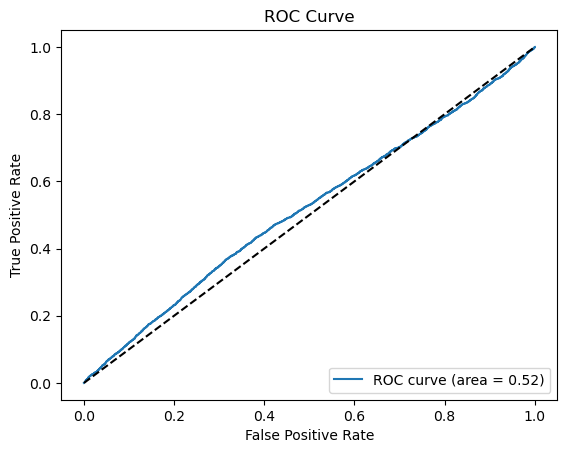

Optimal Threshold: 0.4960924633872402


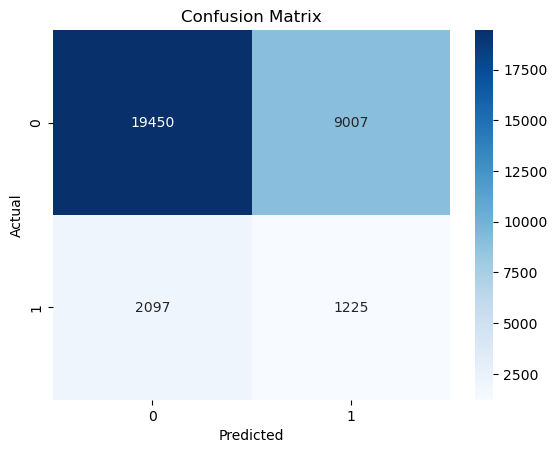

Type 1 Error: 0.31651263309554767
Type 2 Error: 0.6312462372065021


In [32]:
# calculate fpr and tpr for different threshold values
Y_pred = result2.predict(X)
fpr, tpr, thresholds = roc_curve(Y, Y_pred)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# find the threshold that maximizes the AUC
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

Y_pred_class = np.where(Y_pred >= optimal_threshold, 1, 0)

cm = confusion_matrix(Y, Y_pred_class)

# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

#print our type I and II errors
tn, fp, fn, tp = cm.ravel()

type1_error = fp / (fp + tn)
type2_error = fn / (fn + tp)

print("Type 1 Error:", type1_error)
print("Type 2 Error:", type2_error)

### Model 3: Teoh

In [33]:
df3=sample.copy()

In [34]:
df3 = df3[~df3['fiscal_year'].isin([2019, 2020, 2021])]

In [35]:
#creating Y and Xs
df3['Y']=(df3['current_assets_diff']-df3['current_cash_diff']-df3['current_liabilities_diff']+df3['current_debt_diff'])/df3['lag_total_assets']
df3['var1']=1/df3['lag_total_assets']
df3['var2']=df3['rev_diff']/df3['lag_total_assets']

In [36]:
#get the coeffs by applying regress with out intercept function
#since this model does not have intercept based on the formula in lecture slides
teoh_coeff=df3.groupby(['fiscal_year','sic']).apply(regress_wo_intercept,'Y',['var1','var2'])

In [37]:
teoh_coeff.to_csv('teoh_coeff.csv')
Parameters3=pd.read_csv('teoh_coeff.csv')

In [38]:
Parameters3.rename(columns={'var1': 'b1', 'var2': 'b2'}, inplace=True)
Parameters3['sic'] = Parameters3['sic'].astype(str)

In [39]:
#replace var2 to (relta Rev_t-delta AR_t)/(Assets_t-1) based on the formula from the lecture slides
#merged two dataset and calculate residuals
merged_df3 = pd.merge(df3, Parameters3, on=['fiscal_year', 'sic'], how='left')
merged_df3['var2']=(merged_df3['rev_diff']-merged_df3['receivables_total_diff'])/merged_df3['lag_total_assets']

merged_df3['res']=(merged_df3['Y']-(merged_df3['b1']*merged_df3['var1']+merged_df3['b2']*merged_df3['var2'])).abs()

In [40]:
merged_df3.groupby(['restatement'])['res'].agg('mean')

restatement
0    1.396362
1    3.153909
Name: res, dtype: float64

In [41]:
merged_df3.groupby(['res_sec_invest'])['res'].agg('mean')

res_sec_invest
0    1.587842
1    0.501998
Name: res, dtype: float64

In [42]:
X = merged_df3['res']
Y = merged_df3['restatement']

result3 = sm.Logit(Y, X).fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.692077
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            restatement   No. Observations:                31779
Model:                          Logit   Df Residuals:                    31778
Method:                           MLE   Df Model:                            0
Date:                Sat, 08 Apr 2023   Pseudo R-squ.:                  -1.066
Time:                        19:26:03   Log-Likelihood:                -21994.
converged:                       True   LL-Null:                       -10644.
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
res           -0.0102      0.002     -5.678      0.000      -0.014      -0.007
==============================================================================
"""

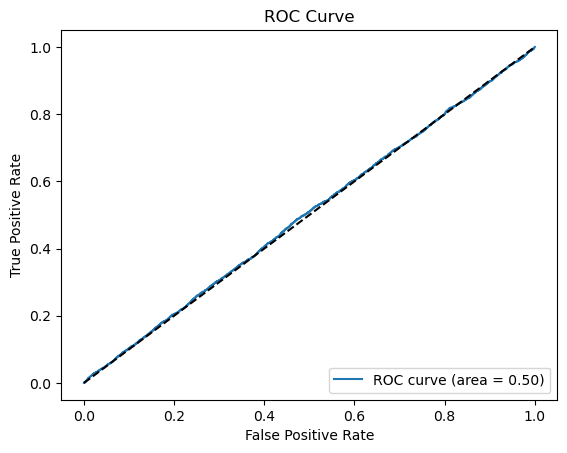

Optimal Threshold: 0.4998662698754848


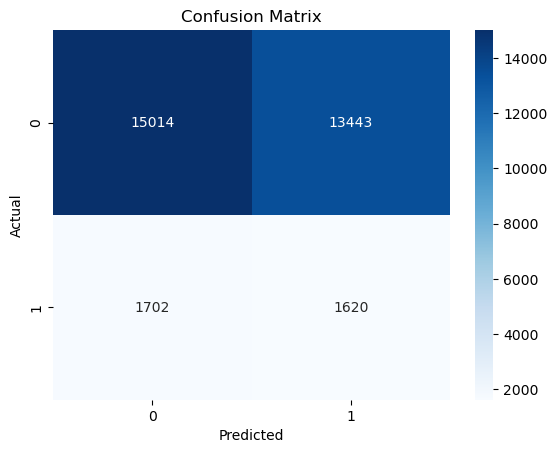

Type 1 Error: 0.47239694978388447
Type 2 Error: 0.5123419626730885


In [43]:
# calculate fpr and tpr for different threshold values
Y_pred = result3.predict(X)
fpr, tpr, thresholds = roc_curve(Y, Y_pred)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# find the threshold that maximizes the AUC
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

Y_pred_class = np.where(Y_pred >= optimal_threshold, 1, 0)

cm = confusion_matrix(Y, Y_pred_class)

# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

#print our type I and II errors
tn, fp, fn, tp = cm.ravel()

type1_error = fp / (fp + tn)
type2_error = fn / (fn + tp)

print("Type 1 Error:", type1_error)
print("Type 2 Error:", type2_error)

# Examine more additional firm-level factors predicting fraud alongside accruals and assess their impact on restatements.

## Output and coeffs by using residuals in Jones model

In [44]:
X = np.column_stack((merged_df['res'],
                    merged_df['caps'],
                    merged_df['dn'],
                    merged_df['ni'],
                    merged_df['dudd'],
                    merged_df['cstkcv'],
                    merged_df['dpact']))

Y = merged_df['restatement']

# fit logistic regression model
result1 = sm.Probit(Y, X).fit()


Optimization terminated successfully.
         Current function value: 0.611684
         Iterations 32


In [45]:
result1.params

x1   -0.011744
x2   -0.000096
x3    0.000049
x4   -0.000108
x5    0.002103
x6   -0.151598
x7   -0.000136
dtype: float64

In [46]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:            restatement   No. Observations:                31779
Model:                         Probit   Df Residuals:                    31772
Method:                           MLE   Df Model:                            6
Date:                Sat, 08 Apr 2023   Pseudo R-squ.:                 -0.8263
Time:                        19:26:04   Log-Likelihood:                -19439.
converged:                       True   LL-Null:                       -10644.
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0117      0.000    -26.179      0.000      -0.013      -0.011
x2         -9.645e-05   4.67e-06    -20.669      0.000      -0.000   -8.73e-05
x3          4.943e-05   6.74e-06      7.336      0.000    3.62e-05    6.26e-05
x4            -0.0001   1.51e-05     -7.161      0.000      -0.000   -7.85e-05
x5             0.0021      0.000      5.202      0.000       0.001       0.003
x6            -0.1516      0.004    -38.032      0.000      -0.159      -0.144
x7            -0.0001   5.99e-06    -22.658      0.000      -0.000      -0.000
==============================================================================
"""

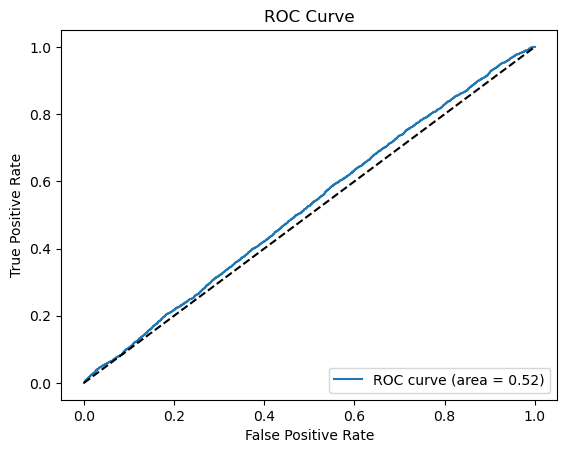

Optimal Threshold: 0.4117632746019774


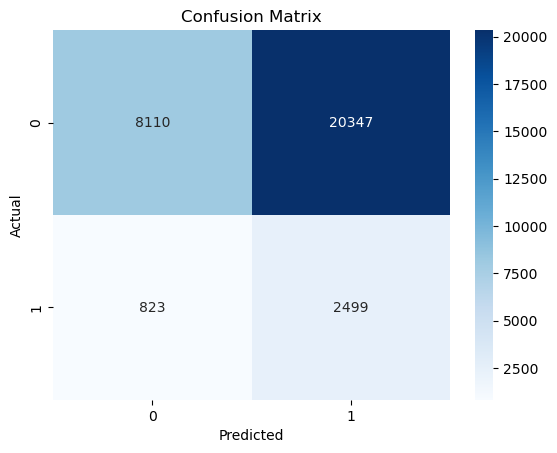

Type 1 Error: 0.7150086094809713
Type 2 Error: 0.2477423239012643


In [47]:
# calculate fpr and tpr for different threshold values
Y_pred = result1.predict(X)
fpr, tpr, thresholds = roc_curve(Y, Y_pred)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# find the threshold that maximizes the AUC
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold1 = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold1)

Y_pred_class = np.where(Y_pred >= optimal_threshold1, 1, 0)

cm = confusion_matrix(Y, Y_pred_class)

# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

#print our type I and II errors
tn, fp, fn, tp = cm.ravel()

type1_error = fp / (fp + tn)
type2_error = fn / (fn + tp)

print("Type 1 Error:", type1_error)
print("Type 2 Error:", type2_error)

## Output and coeffs by using residuals in modified Jones model

In [48]:
X = np.column_stack((merged_df2['res'],
                    merged_df2['caps'],
                    merged_df2['dn'],
                    merged_df2['ni'],
                    merged_df2['dudd'],
                    merged_df2['cstkcv'],
                    merged_df2['dpact']))

Y = merged_df2['restatement']

result2 = sm.Probit(Y, X).fit()

Optimization terminated successfully.
         Current function value: 0.614045
         Iterations 22


In [49]:
result2.params

x1   -0.004256
x2   -0.000097
x3    0.000050
x4   -0.000108
x5    0.002107
x6   -0.152933
x7   -0.000136
dtype: float64

In [50]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:            restatement   No. Observations:                31779
Model:                         Probit   Df Residuals:                    31772
Method:                           MLE   Df Model:                            6
Date:                Sat, 08 Apr 2023   Pseudo R-squ.:                 -0.8333
Time:                        19:26:04   Log-Likelihood:                -19514.
converged:                       True   LL-Null:                       -10644.
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0043      0.000     -9.189      0.000      -0.005      -0.003
x2         -9.744e-05   4.67e-06    -20.874      0.000      -0.000   -8.83e-05
x3          4.975e-05   6.74e-06      7.380      0.000    3.65e-05     6.3e-05
x4            -0.0001   1.51e-05     -7.185      0.000      -0.000   -7.88e-05
x5             0.0021      0.000      5.207      0.000       0.001       0.003
x6            -0.1529      0.004    -38.351      0.000      -0.161      -0.145
x7            -0.0001      6e-06    -22.744      0.000      -0.000      -0.000
==============================================================================
"""

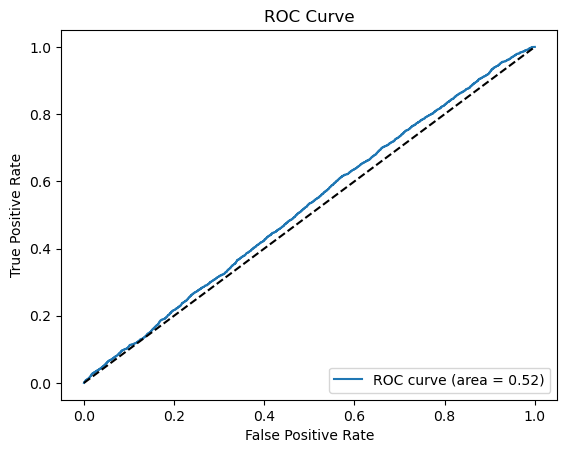

Optimal Threshold: 0.46456335604664045


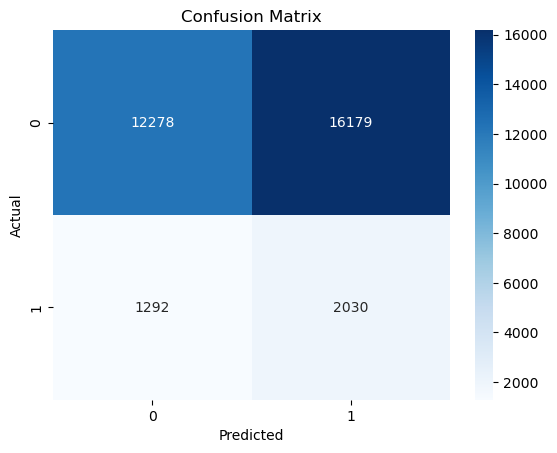

Type 1 Error: 0.568542010753066
Type 2 Error: 0.3889223359422035


In [51]:
# calculate fpr and tpr for different threshold values
Y_pred = result2.predict(X)
fpr, tpr, thresholds = roc_curve(Y, Y_pred)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# find the threshold that maximizes the AUC
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold2 = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold2)

Y_pred_class = np.where(Y_pred >= optimal_threshold2, 1, 0)

cm = confusion_matrix(Y, Y_pred_class)

# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

#print our type I and II errors
tn, fp, fn, tp = cm.ravel()

type1_error = fp / (fp + tn)
type2_error = fn / (fn + tp)

print("Type 1 Error:", type1_error)
print("Type 2 Error:", type2_error)

## Output and coeffs by using residuals in Teoh model

In [52]:
X = np.column_stack((merged_df3['res'],
                    merged_df3['caps'],
                    merged_df3['dn'],
                    merged_df3['ni'],
                    merged_df3['dudd'],
                    merged_df3['cstkcv'],
                    merged_df3['dpact']))
Y = merged_df3['restatement']

result3 = sm.Probit(Y, X).fit()

Optimization terminated successfully.
         Current function value: 0.615229
         Iterations 22


In [53]:
result3.params

x1   -0.000959
x2   -0.000098
x3    0.000050
x4   -0.000108
x5    0.002109
x6   -0.153334
x7   -0.000137
dtype: float64

In [54]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:            restatement   No. Observations:                31779
Model:                         Probit   Df Residuals:                    31772
Method:                           MLE   Df Model:                            6
Date:                Sat, 08 Apr 2023   Pseudo R-squ.:                 -0.8369
Time:                        19:26:05   Log-Likelihood:                -19551.
converged:                       True   LL-Null:                       -10644.
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0010      0.000     -4.346      0.000      -0.001      -0.001
x2         -9.774e-05   4.67e-06    -20.937      0.000      -0.000   -8.86e-05
x3          4.982e-05   6.74e-06      7.390      0.000    3.66e-05     6.3e-05
x4            -0.0001   1.51e-05     -7.193      0.000      -0.000   -7.89e-05
x5             0.0021      0.000      5.210      0.000       0.001       0.003
x6            -0.1533      0.004    -38.449      0.000      -0.161      -0.146
x7            -0.0001      6e-06    -22.770      0.000      -0.000      -0.000
==============================================================================
"""

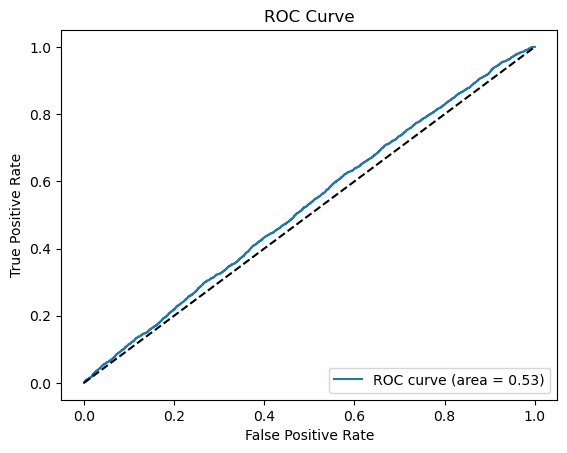

Optimal Threshold: 0.46461559069781516


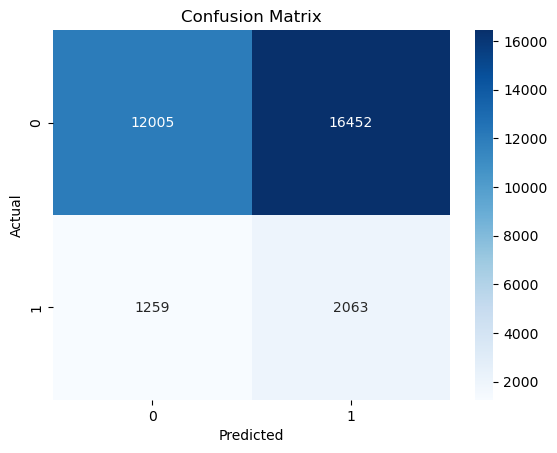

Type 1 Error: 0.5781354324067892
Type 2 Error: 0.3789885611077664


In [55]:
# calculate fpr and tpr for different threshold values
Y_pred = result3.predict(X)
fpr, tpr, thresholds = roc_curve(Y, Y_pred)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# find the threshold that maximizes the AUC
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold3 = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold3)

Y_pred_class = np.where(Y_pred >= optimal_threshold3, 1, 0)

cm = confusion_matrix(Y, Y_pred_class)

# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

#print our type I and II errors
tn, fp, fn, tp = cm.ravel()

type1_error = fp / (fp + tn)
type2_error = fn / (fn + tp)

print("Type 1 Error:", type1_error)
print("Type 2 Error:", type2_error)


# Apply coefficients from 2) to predict 100 firms likely to restate earnings in 2019-2021 and verify predictions using actual restatement data.

## By using Jones model

In [56]:
df_test=sample.copy()

In [57]:
df_test = df_test[df_test['fiscal_year'].isin([2019, 2020, 2021])]

In [58]:
#creating Y and Xs
df_test['Y']=(df_test['current_assets_diff']-df_test['current_cash_diff']-df_test['current_liabilities_diff']-df_test['depreciation'])/df_test['lag_total_assets']
df_test['var1']=1/df_test['lag_total_assets']
df_test['var2']=df_test['rev_diff']/df_test['lag_total_assets']
df_test['var3']=df_test['ppe']/df_test['lag_total_assets']

In [59]:
#get the coeffs
jones_coeff_test=df_test.groupby(['fiscal_year','sic']).apply(regress,'Y',['var1','var2','var3'])

In [60]:
jones_coeff_test.to_csv('jones_coeff_test.csv')
Parameters_test=pd.read_csv('jones_coeff_test.csv')

In [61]:
Parameters_test.rename(columns={'var1': 'b1', 'var2': 'b2', 'var3': 'b3','intercept':'b0'}, inplace=True)
Parameters_test['sic'] = Parameters_test['sic'].astype(str)

In [62]:
#merged two dataset and calculate residuals
merged_df_test = pd.merge(df_test, Parameters_test, on=['fiscal_year', 'sic'], how='left')
merged_df_test['res']=(merged_df_test['Y']-(merged_df_test['b0']+merged_df_test['b1']*merged_df_test['var1']+merged_df_test['b2']*merged_df_test['var2']+merged_df_test['b3']*merged_df_test['var3'])).abs()

In [63]:
X_test = np.column_stack((merged_df_test['res'],
                          merged_df_test['caps'],
                          merged_df_test['dn'],
                          merged_df_test['ni'],
                          merged_df_test['dudd'],
                          merged_df_test['cstkcv'],
                         merged_df_test['dpact']))

# use the fitted Probit model to predict the values for the test set
Y_pred = result1.predict(X_test)


In [64]:
#concat info about testdata and the prob of the predictions
results_df = pd.concat([merged_df_test[['fiscal_year','gvkey','restatement']], pd.DataFrame(Y_pred, columns=['Prob_Restate'])], axis=1)

# sort the dataframe by predicted probabilities in descending order
results_df = results_df.sort_values(by='Prob_Restate', ascending=False)


# select the top 100 companies with the highest prob for year 2019
top100 = results_df.head(100)
count = (top100['restatement']==1).sum()
count

8

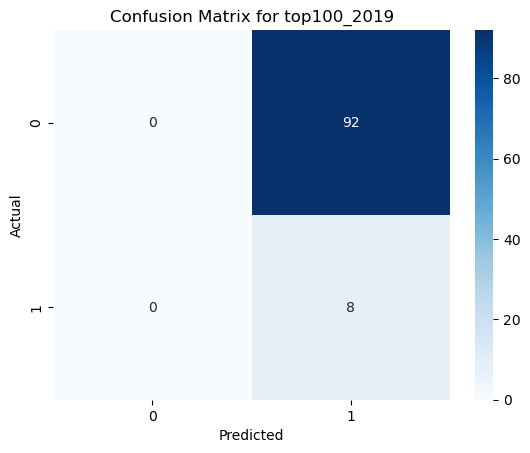

In [65]:
# prediction with redisuals from Jones model
Y_top100 = top100['restatement']
X_top100 = top100['Prob_Restate']

Y_pred_class_top100 = np.where(X_top100 >= optimal_threshold1, 1, 0)

cm_top100 = confusion_matrix(Y_top100, Y_pred_class_top100)

# plot the confusion matrix
sns.heatmap(cm_top100, annot=True, cmap="Blues", fmt="d", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix for top100_2019")
plt.show()

## By using modified Jones model

In [66]:
df2_test=sample.copy()

In [67]:
df2_test = df2_test[df2_test['fiscal_year'].isin([2019, 2020, 2021])]

In [68]:
#creating Y and Xs
df2_test['Y']=(df2_test['current_assets_diff']-df2_test['current_cash_diff']-df2_test['current_liabilities_diff']-df2_test['depreciation']+df2_test['current_debt_diff'])/df2_test['lag_total_assets']
df2_test['var1']=1/df2_test['lag_total_assets']
df2_test['var2']=df2_test['rev_diff']/df2_test['lag_total_assets']
df2_test['var3']=df2_test['ppe']/df2_test['lag_total_assets']

In [69]:
#get the coeffs
modified_jones_coeff_test=df2_test.groupby(['fiscal_year','sic']).apply(regress,'Y',['var1','var2','var3'])

In [70]:
modified_jones_coeff_test.to_csv('modified_jones_coeff_test.csv')
Parameters2_test=pd.read_csv('modified_jones_coeff_test.csv')

In [71]:
Parameters2_test.rename(columns={'var1': 'b1', 'var2': 'b2', 'var3': 'b3','intercept':'b0'}, inplace=True)
Parameters2_test['sic'] = Parameters2_test['sic'].astype(str)

In [72]:
#merged two dataset and calculate residuals
merged_df2_test = pd.merge(df2_test, Parameters2_test, on=['fiscal_year', 'sic'], how='left')
merged_df2_test['res']=(merged_df2_test['Y']-(merged_df2_test['b0']+merged_df2_test['b1']*merged_df2_test['var1']+merged_df2_test['b2']*merged_df2_test['var2']+merged_df2_test['b3']*merged_df2_test['var3'])).abs()

In [73]:
X_test = np.column_stack((merged_df2_test['res'],
                          merged_df2_test['caps'],
                          merged_df2_test['dn'],
                          merged_df2_test['ni'],
                          merged_df2_test['dudd'],
                          merged_df2_test['cstkcv'],
                          merged_df2_test['dpact']))
# use the fitted Probit model to predict the values for the test set
Y_pred = result2.predict(X_test)


In [74]:
#concat info about testdata and the prob of the predictions
results_df = pd.concat([merged_df2_test[['fiscal_year','gvkey','restatement']], pd.DataFrame(Y_pred, columns=['Prob_Restate'])], axis=1)

# sort the dataframe by predicted probabilities in descending order
results_df = results_df.sort_values(by='Prob_Restate', ascending=False)


# select the top 100 companies with the highest prob for year 2019
top100 = results_df.head(100)
count = (top100['restatement']==1).sum()
count

7

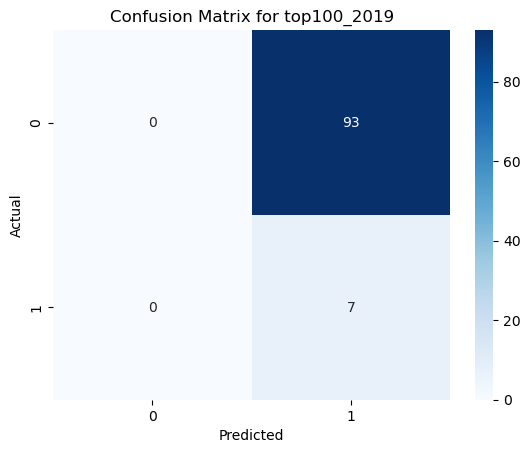

In [75]:
# prediction with redisuals from Jones model
Y_top100 = top100['restatement']
X_top100 = top100['Prob_Restate']

Y_pred_class_top100 = np.where(X_top100 >= optimal_threshold2, 1, 0)

cm_top100 = confusion_matrix(Y_top100, Y_pred_class_top100)

# plot the confusion matrix
sns.heatmap(cm_top100, annot=True, cmap="Blues", fmt="d", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix for top100_2019")
plt.show()

## By uing Teoh model 

In [76]:
df3_test=sample.copy()

In [77]:
df3_test = df3_test[df3_test['fiscal_year'].isin([2019, 2020, 2021])]

In [78]:
#creating Y and Xs
df3_test['Y']=(df3_test['current_assets_diff']-df3_test['current_cash_diff']-df3_test['current_liabilities_diff']+df3_test['current_debt_diff'])/df3_test['lag_total_assets']
df3_test['var1']=1/df3_test['lag_total_assets']
df3_test['var2']=df3_test['rev_diff']/df3_test['lag_total_assets']

In [79]:
#get the coeffs by applying regress with out intercept function
#since this model does not have intercept based on the formula in lecture slides
teoh_coeff_test=df3_test.groupby(['fiscal_year','sic']).apply(regress_wo_intercept,'Y',['var1','var2'])

In [80]:
teoh_coeff_test.to_csv('teoh_coeff_test.csv')
Parameters3_test=pd.read_csv('teoh_coeff_test.csv')

In [81]:
Parameters3_test.rename(columns={'var1': 'b1', 'var2': 'b2'}, inplace=True)
Parameters3_test['sic'] = Parameters3_test['sic'].astype(str)

In [82]:
#replace var2 to (relta Rev_t-delta AR_t)/(Assets_t-1) based on the formula from the lecture slides
#merged two dataset and calculate residuals
merged_df3_test = pd.merge(df3_test, Parameters3_test, on=['fiscal_year', 'sic'], how='left')
merged_df3_test['var2']=(merged_df3_test['rev_diff']-merged_df3_test['receivables_total_diff'])/merged_df3_test['lag_total_assets']

merged_df3_test['res']=(merged_df3_test['Y']-(merged_df3_test['b1']*merged_df3_test['var1']+merged_df3_test['b2']*merged_df3_test['var2'])).abs()

In [83]:
X_test = np.column_stack((merged_df3_test['res'],
                          merged_df3_test['caps'],
                          merged_df3_test['dn'],
                          merged_df3_test['ni'],
                          merged_df3_test['dudd'],
                          merged_df3_test['cstkcv'],
                          merged_df3_test['dpact']))
# use the fitted Probit model to predict the values for the test set
Y_pred = result3.predict(X_test)


In [84]:
#concat info about testdata and the prob of the predictions
results_df = pd.concat([merged_df3_test[['fiscal_year','gvkey','restatement']], pd.DataFrame(Y_pred, columns=['Prob_Restate'])], axis=1)

# sort the dataframe by predicted probabilities in descending order
results_df = results_df.sort_values(by='Prob_Restate', ascending=False)


# select the top 100 companies with the highest prob for year 2019
top100 = results_df.head(100)
count = (top100['restatement']==1).sum()
count

7

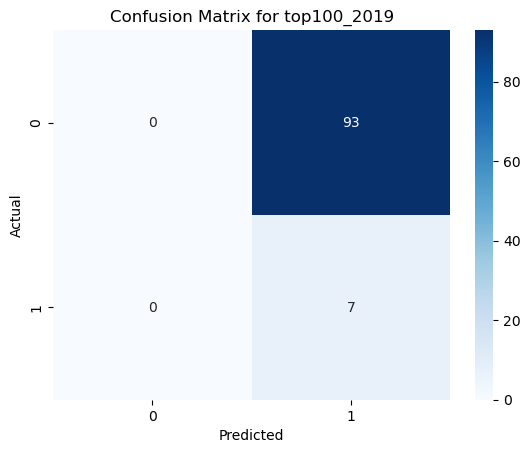

In [85]:
# prediction with redisuals from Jones model
Y_top100 = top100['restatement']
X_top100 = top100['Prob_Restate']

Y_pred_class_top100 = np.where(X_top100 >= optimal_threshold3, 1, 0)

cm_top100 = confusion_matrix(Y_top100, Y_pred_class_top100)

# plot the confusion matrix
sns.heatmap(cm_top100, annot=True, cmap="Blues", fmt="d", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix for top100_2019")
plt.show()

# Create an annual EM index, re-estimate 2) using EM index and other variables, identify 10 likely restating firms, and qualitatively narrow down to 5 with the highest restatement potential.

In [86]:
# calculate EM for data between 2012-2018
EM_1=merged_df.groupby('fiscal_year')['res'].apply(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))
EM_2=merged_df2.groupby('fiscal_year')['res'].apply(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))
EM_3=merged_df3.groupby('fiscal_year')['res'].apply(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))
EM_train=EM_1+EM_2+EM_3
EM_train = pd.DataFrame({'EM': EM_train})

In [87]:
Q4_train=merged_df.copy()

In [88]:
final_train = pd.concat([EM_train,Q4_train],axis=1)

In [89]:
X = np.column_stack((final_train['EM'],
                    final_train['caps'],
                    final_train['dn'],
                    final_train['ni'],
                    final_train['dudd'],
                    final_train['cstkcv'],
                    final_train['dpact']))

Y = final_train['restatement']

result_final = sm.Probit(Y, X).fit()

Optimization terminated successfully.
         Current function value: 0.388508
         Iterations 16


In [90]:
result_final.params

x1   -0.072942
x2   -0.000008
x3    0.000021
x4   -0.000115
x5    0.001813
x6   -0.049121
x7   -0.000054
dtype: float64

In [91]:
# calculate EM for data between 2019-2021
EM_1=merged_df_test.groupby('fiscal_year')['res'].apply(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))
EM_2=merged_df2_test.groupby('fiscal_year')['res'].apply(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))
EM_3=merged_df3_test.groupby('fiscal_year')['res'].apply(lambda x: pd.qcut(x, 10, labels=False,duplicates='drop'))
EM_test=EM_1+EM_2+EM_3
EM_test = pd.DataFrame({'EM': EM_test})

In [92]:
Q4_test=merged_df_test.copy()

In [93]:
final_test = pd.concat([EM_test,Q4_test],axis=1)

In [94]:
# create a boolean mask to filter out rows with year 2019 and 2020
mask = (final_test['fiscal_year'] != 2019) & (final_test['fiscal_year'] != 2020)
# apply the boolean mask to exclude rows with year 2019 and 2020
final_test = final_test[mask]

In [95]:
X_test = np.column_stack((final_test['EM'],
                          final_test['caps'],
                          final_test['dn'],
                          final_test['ni'],
                          final_test['dudd'],
                          final_test['cstkcv'],
                          final_test['dpact']))

# use the fitted Probit model to predict the values for the test set
Y_pred = result_final.predict(X_test)

In [96]:
final_test=final_test.reset_index()

In [97]:
#concat info about testdata and the prob of the predictions
results_df = pd.concat([final_test[['gvkey','restatement']], pd.DataFrame(Y_pred, columns=['Prob_Restate'])], axis=1)

# sort the dataframe by predicted probabilities in descending order
results_df = results_df.sort_values(by='Prob_Restate', ascending=False)

# select the top companies with the highest
top_10 = results_df.head(10)

count = (top_10['restatement']==1).sum()
print('Correctly identified '+str(count)+' firms in 2021.')

Correctly identified 3 firms in 2021.


In [98]:
top_10

,gvkey,restatement,Prob_Restate
65,002403,0,0.673395
3954,177637,0,0.622035
2487,037658,1,0.504585
1176,023082,1,0.503618
1780,032098,1,0.501093
2708,039225,0,0.500442
2820,040723,0,0.500184
2854,041468,0,0.500043
2840,041884,0,0.500033
1418,026478,0,0.499995


Optimal Threshold: 0.5010926001031631


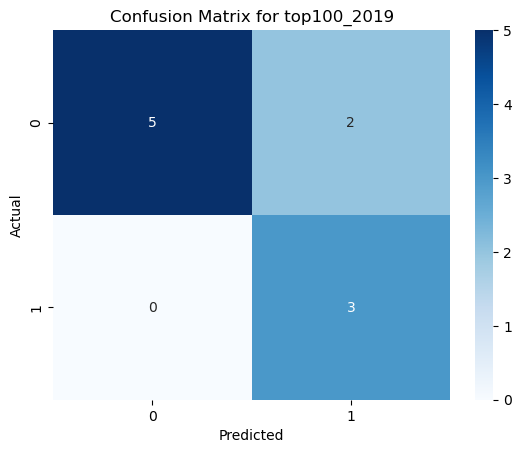

In [99]:
# prediction for 2021
Y_top10 = top_10['restatement']
X_top10 = top_10['Prob_Restate']

fpr, tpr, thresholds = roc_curve(Y_top10, X_top10)


# find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

Y_pred_class_top10 = np.where(X_top10 >= optimal_threshold, 1, 0)

cm_top10 = confusion_matrix(Y_top10, Y_pred_class_top10)

# plot the confusion matrix
sns.heatmap(cm_top10, annot=True, cmap="Blues", fmt="d", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix for top100_2019")
plt.show()